In [1]:
import tensorflow as tf
import numpy as np
import typing
import pandas as pd
import seaborn as sns
from tensorflow import keras
from hydra import compose, initialize
from omegaconf import OmegaConf
from musicnet.config.Config import Config
from musicnet.preprocessing.utils import get_datasets_info, load_vocabs
from musicnet.preprocessing.wav_chunks_tfrecord.utils import create_tf_record_ds
from musicnet.models.utils import MODEL_PATH
from musicnet.preprocessing.dataset.base import DsName
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

2024-08-29 13:17:05.001884: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 13:17:05.001914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 13:17:05.001937: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
initialize(version_base=None, config_path="../scripts")
cfg = compose(config_name="defaults", overrides=["stages=[]", "exp=False"])

In [3]:
config = typing.cast(Config, OmegaConf.to_object(cfg))
ds_infos = get_datasets_info(config)

datasets: dict[DsName, tf.data.Dataset] = {}
for ds_info in ds_infos:
    if ds_info.name in ["val", "test"]:
        datasets[ds_info.name] = create_tf_record_ds(ds_info.config, ds_info.name, shuffle=False)

model = keras.models.load_model(MODEL_PATH)

y_true = np.concatenate([y for x, y in datasets["test"]], axis=0)
y_pred = model.predict(datasets["test"])
y_pred = tf.sigmoid(y_pred)
y_pred = y_pred.numpy()

print("y_true shape", y_true.shape)
print("y_pred shape", y_pred.shape)


320/320 [==============================] - 6s 16ms/step
y_true shape (2560, 1000, 85)
y_pred shape (2560, 1000, 85)


In [5]:
# TODO: Establish what kind of metrics I want to have here:
# - bar plot of precision/f1 grouped by individual notes
# - bar plot of precision/f1 grouped by numer of silmulataneous notes
# - bar plot of precision/f1 grouped by note_length bins
# - bar plot of precision/f1 grouped by time_playing / time_remaining bins
# - If midi is a source: bar plot of precision/f1 grouped by velocity bins (like 30-40, 40-50, 50-60 etc.) 
# - visualization of some fragment of predictions vs true values (something like notebooks/utils:y_vs_y_pred_vis)

In [4]:
y_true = y_true.reshape(-1, y_true.shape[-1])
y_pred = y_pred.reshape(-1, y_pred.shape[-1])

In [5]:
instruments_vocab, notes_vocab = load_vocabs(config)

In [7]:
notes_vocab

{20: 0,
 21: 1,
 22: 2,
 23: 3,
 24: 4,
 25: 5,
 26: 6,
 27: 7,
 28: 8,
 29: 9,
 30: 10,
 31: 11,
 32: 12,
 33: 13,
 34: 14,
 35: 15,
 36: 16,
 37: 17,
 38: 18,
 39: 19,
 40: 20,
 41: 21,
 42: 22,
 43: 23,
 44: 24,
 45: 25,
 46: 26,
 47: 27,
 48: 28,
 49: 29,
 50: 30,
 51: 31,
 52: 32,
 53: 33,
 54: 34,
 55: 35,
 56: 36,
 57: 37,
 58: 38,
 59: 39,
 60: 40,
 61: 41,
 62: 42,
 63: 43,
 64: 44,
 65: 45,
 66: 46,
 67: 47,
 68: 48,
 69: 49,
 70: 50,
 71: 51,
 72: 52,
 73: 53,
 74: 54,
 75: 55,
 76: 56,
 77: 57,
 78: 58,
 79: 59,
 80: 60,
 81: 61,
 82: 62,
 83: 63,
 84: 64,
 85: 65,
 86: 66,
 87: 67,
 88: 68,
 89: 69,
 90: 70,
 91: 71,
 92: 72,
 93: 73,
 94: 74,
 95: 75,
 96: 76,
 97: 77,
 98: 78,
 99: 79,
 100: 80,
 101: 81,
 102: 82,
 103: 83,
 104: 84}

In [65]:
def plot_f1_by_class(y_true: np.ndarray, y_pred: np.ndarray):
    f1_per_note = keras.metrics.F1Score(average=None, threshold=0.5)(y_true, y_pred).numpy()
    df = pd.DataFrame({
        "note": notes_vocab.keys(),
        "f1_score": f1_per_note
    })
    ax = sns.barplot(data=df, x="note", y="f1_score")
    ax.bar_label(ax.containers[0], fontsize=10)
    for bar in ax.patches:
        g = (bar.get_height() - min(f1_per_note)) / (max(f1_per_note) - min(f1_per_note))
        bar.set_color((1 - g, g, 0.))

In [80]:
def plot_average_fp_fn_count_by_silmultaneous(y_true: np.ndarray, y_pred: np.ndarray):
    max_silmultaneous = int(np.max(y_true.sum(axis=1)))
    fps = []
    fns = []
    for s in range(0, max_silmultaneous + 1):
        indices = y_true.sum(axis=1) == s
        fps.append(((y_true[indices] == False) & (y_pred[indices] >= 0.5)).sum(axis=1).mean())
        fns.append(((y_true[indices] == True) & (y_pred[indices] < 0.5)).sum(axis=1).mean())
    df = pd.DataFrame({
        "silmultaneous_notes": list(range(0, max_silmultaneous + 1)) * 2,
        "metric": ["fp"] * len(fps) + ["fn"] * len(fns),
        "value": fps + fns
    })
    ax = sns.barplot(data=df, x="silmultaneous_notes", y="value", hue="metric")
    ax.bar_label(ax.containers[0], fontsize=10)
    ax.bar_label(ax.containers[1], fontsize=10)
    # for bar in ax.patches:
    #     g = (bar.get_height() - min(fps)) / (max(fps) - min(fps))
    #     bar.set_color((1 - g, g, 0.))

In [57]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray):
    # For each note we calculate the percentage of false positives of other notes
    conf_matrix = []
    for n in notes_vocab.values():
        indices = y_true[:, n] == True
        false_positives = ((y_pred[indices] > 0.5) & (y_true[indices] == False)).sum(axis=0) / y_true.shape[0]
        conf_matrix.append(false_positives)
    conf_matrix = np.array(conf_matrix)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=list(notes_vocab.keys()))
    plt.figure(figsize=(10, 10))
    plt.title("True labels vs false positives")
    disp.plot(ax=plt.gca())

In [63]:
np.unique(y_true.sum(axis=1), return_counts=True)

(array([0., 1., 2., 3.], dtype=float32),
 array([ 85514, 225682, 207017,  61787]))

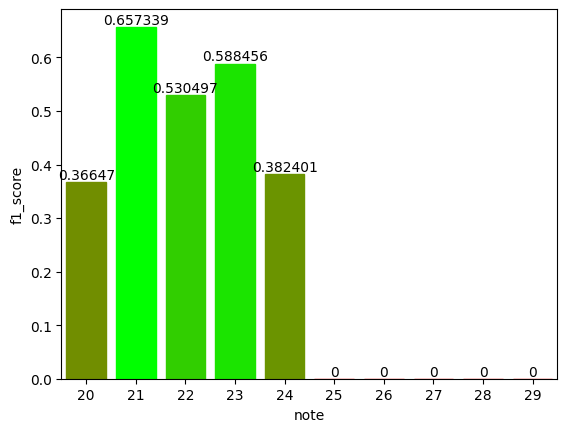

In [66]:
plot_f1_by_class(y_true, y_pred)

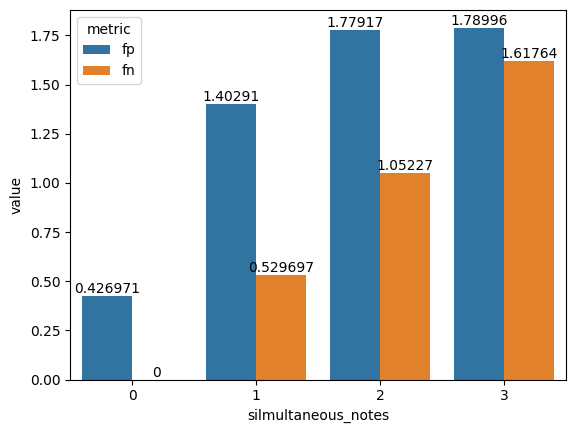

In [81]:
plot_average_fp_fn_count_by_silmultaneous(y_true, y_pred)

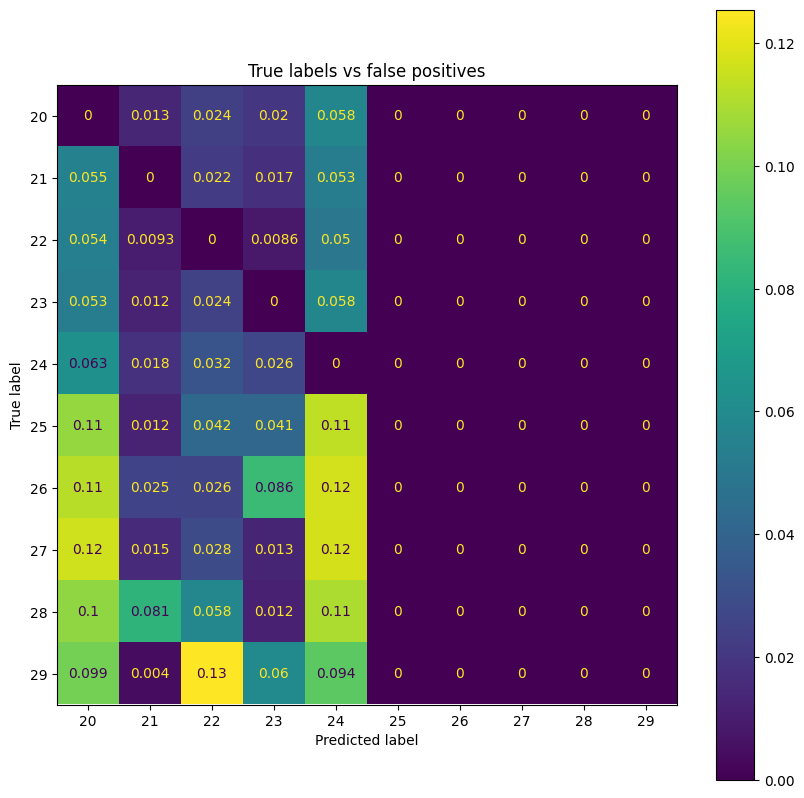

In [44]:
plot_confusion_matrix(y_true, y_pred)